In [1]:
from sklearn.pipeline import Pipeline , FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from nltk.corpus import stopwords
import nltk
from nltk.tokenize.stanford_segmenter import StanfordSegmenter
import gensim

import os
from collections import defaultdict
import pickle
import re
import unicodedata


In [2]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        
        temp = np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(100)], axis=0)
                for words in X
            ])
        return temp

In [3]:
class textClassificationModels():
    
    def load_data(self,url='4-dialects-tweets.xlsx'):    
#         self.df = pd.read_csv(url, encoding = 'utf8')
        self.df = pd.read_excel(url, encoding = 'utf8')
    
    
        # let X be a list of tokenized texts (i.e. list of lists of tokens)
        X = []
        for t in self.df['tweets']:
            X.append(t.split())
            
        gensim_model = gensim.models.Word2Vec(X, size=100)
        self.w2v = dict(zip(gensim_model.wv.index2word, gensim_model.wv.syn0))

        print("total rows : ",len(self.df))
        return self.df
    
    def train(self,algo , Auto_Tune = False , nfolds = 10):
        algos = []
        pipe_parms = []
        add_tfidf = False
        if algo == 'N-Gram':
            algos.append(('word_vec', CountVectorizer(analyzer='word', ngram_range=(1,3))))
            algos.append(('char_vec', CountVectorizer(analyzer='char', ngram_range=(1,5))))
            
        elif algo == 'N-gram_and_tfidf':
            algos.append(('word_vec', CountVectorizer(analyzer='word', ngram_range=(1,3))))
            algos.append(('char_vec', CountVectorizer(analyzer='char', ngram_range=(3,5))))
            add_tfidf =  True
            
        elif algo == "word2vic":
            algos.append(("word2vec vectorizer", TfidfEmbeddingVectorizer(self.w2v)))
            
        
        else:
            print("Choose algorithem :")
            print("1- \t" , "N-Gram")
            print("2- \t" , "vac-prune")
            print("3- \t" , "All")
            return None
        
        pipe_parms.append(
                        ('union', FeatureUnion(algos)),
                        )
        if add_tfidf:
            pipe_parms.append(('tfidf', TfidfTransformer(sublinear_tf=True)))

        pipe_parms.append(
                        ('clf-svm', svm.LinearSVC(C=0.01)),
                        )
        
        
#         text_clf_svm = Pipeline([
#                         ('union', FeatureUnion(algos)),
#                         ('clf-svm', svm.LinearSVC(C=0.01)),
#                         ])
        text_clf_svm = Pipeline(pipe_parms)
        
        Cs = [0.001, 0.01, 0.1, 1, 10]
#         Cs = [0.1, 0.5, 1, 1.5, 5]
        parameters = {
         }
        if Auto_Tune:
            parameters['clf-svm__C']= Cs


#         nfolds = 10
#         text_clf = GridSearchCV(text_clf_svm, parameters ,cv=nfolds)
#         self.text_clf = text_clf.fit(self.train_x, self.train_y)


        self.text_clf = text_clf_svm.fit(self.train_x, self.train_y)
        
        return self.text_clf
        

    def predict(self ,text):
        predicted = self.text_clf.predict(text)
        return predicted

    def split_data(self,test_size = 0.3):
        train, test = train_test_split(self.df, test_size=test_size)

        self.train_x = train['tweets']#.drop('dialect', 1)
        train_y = train['dialect']

        self.test_x = test['tweets']#.drop('dialect', 1)
        test_y = test['dialect']
        
        print("train_x shape : ",self.train_x.shape)
        print("train_y shape : ",train_y.shape)
        print("test_x shape : ",self.test_x.shape)
        print("test_y shape : ",test_y.shape)

        # label encode the target variable 
        encoder = preprocessing.LabelEncoder()
        self.train_y = encoder.fit_transform(train_y)
        self.test_y = encoder.fit_transform(test_y)
        self.encoder = encoder
        return True
    
    def getpredection_labels(self,pred_arr):
        return self.encoder.inverse_transform(pred_arr)
    
    def clean_data(self):
        self.df['tweets'].apply(self.manual_clean_data)
        return self.df
    
    def manual_clean_data(self,x):
        return self.remove_stop_words(self.strip_numbers(self.strip_punctuation(self.tweets_clean_data(x))))
    
    def strip_punctuation(self,text):
        punctutation_cats = set(['Pc', 'Pd', 'Ps', 'Pe', 'Pi', 'Pf', 'Po'])
        return  ''.join(x for x in text if unicodedata.category(x)
                       not in punctutation_cats)

    def strip_numbers(self,text):
        NUMBER_PATTERN = re.compile('|'.join(['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']), re.UNICODE)
        return re.sub(NUMBER_PATTERN, u'', text)

    def tweets_clean_data(self,x):
    #     x = re.sub(r'#\w+ ?', '', x)
    #     x = re.sub(r'http\S+', '', x)
        return re.sub(r"(?:\@|https?\://)\S+", " ", x)
    
    def remove_stop_words(self,x):
        sf = stopwords.fileids()
        if 'arabic' not in sf:
            nltk.download("stopwords")
        stopwords_list = stopwords.words('arabic')

        return ''.join(w for w in x.split() if w
                       not in stopwords_list)
    

        
        
    def print_confusion_matrix(self,Y_test , Y_pred, labels):
        cm = confusion_matrix(Y_test, Y_pred)
        confusion_mc = confusion_matrix(Y_test, Y_pred)
        n = len(labels)
        df_cm = pd.DataFrame(confusion_mc, 
                             index = [i for i in range(0,n)], columns = [i for i in range(0,n)])

        plt.figure(figsize=(7.5,6))
        sns.heatmap(df_cm, annot=True, xticklabels=labels, yticklabels=labels)
        plt.title('SVM Linear Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(Y_test, Y_pred)))
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        
        
    def print_classification_report(self, Y_test ,Y_pred , labels):
        print(classification_report(Y_test, Y_pred, target_names=labels))
        
    def print_evaluate_reports(self):
        Y_pred = list(self.text_clf.predict(self.test_x))
        Y_test = self.test_y
#         labels = ['eg','sy','sa','alg']
        labels = set(Y_pred)
        labels = sorted(labels)
        labels = self.getpredection_labels(labels)
        try:
            self.print_classification_report(Y_test , Y_pred , labels)
        except Exception as e:
            print(e)
        try:
            self.print_confusion_matrix(Y_test , Y_pred , labels)
        except Exception as e:
            print(e)



In [4]:
model =textClassificationModels()

In [5]:
df = model.load_data('4-dialects-tweets.xlsx')
df = model.clean_data()
df.describe(include='all')

/Users/mac/Envs/dialect-env/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


total rows :  108440


,tweets,dialect
count,108440,108440
unique,103696,4
top,يارب,sa
freq,108,28738


In [6]:
df.groupby('dialect').size()

dialect
alg    26742
eg     28016
sa     28738
sy     24944
dtype: int64

In [7]:
model.split_data(0.3)

train_x shape :  (75908,)
train_y shape :  (75908,)
test_x shape :  (32532,)
test_y shape :  (32532,)


True

# word2vec

In [8]:
model.train('word2vic')

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('word2vec vectorizer',
                                                 <__main__.TfidfEmbeddingVectorizer object at 0x11dc3b410>)])),
                ('clf-svm', LinearSVC(C=0.01))])

              precision    recall  f1-score   support

         alg       0.43      0.32      0.36      8088
          eg       0.32      0.40      0.35      8278
          sa       0.34      0.52      0.41      8663
          sy       0.41      0.15      0.22      7503

    accuracy                           0.35     32532
   macro avg       0.37      0.35      0.34     32532
weighted avg       0.37      0.35      0.34     32532



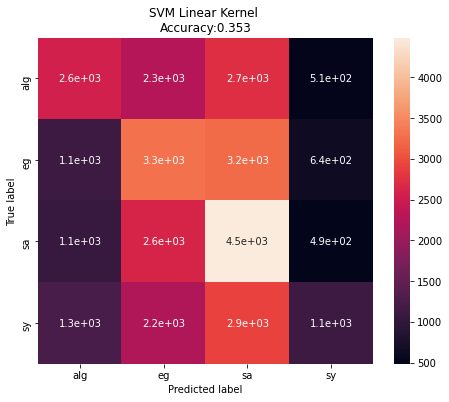

In [9]:
model.print_evaluate_reports()

# N-gram (1-5)char and (1-3)words and tfidf (sublinear_tf)

In [10]:
model.train('N-gram_and_tfidf')

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('word_vec',
                                                 CountVectorizer(ngram_range=(1,
                                                                              3))),
                                                ('char_vec',
                                                 CountVectorizer(analyzer='char',
                                                                 ngram_range=(3,
                                                                              5)))])),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('clf-svm', LinearSVC(C=0.01))])

              precision    recall  f1-score   support

         alg       0.79      0.85      0.82      8088
          eg       0.81      0.77      0.79      8278
          sa       0.75      0.85      0.80      8663
          sy       0.84      0.69      0.76      7503

    accuracy                           0.79     32532
   macro avg       0.80      0.79      0.79     32532
weighted avg       0.80      0.79      0.79     32532



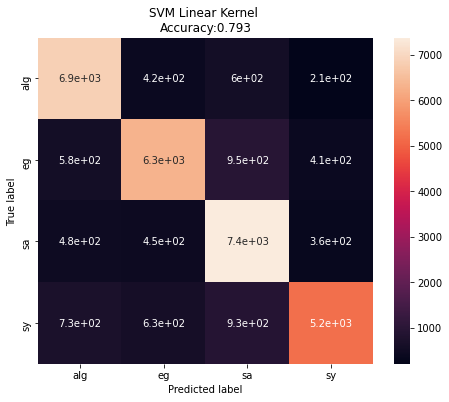

In [11]:
model.print_evaluate_reports()

# N-gram (1-5)char and (1-3)words

In [12]:
model.train('N-Gram')

/Users/mac/Envs/dialect-env/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('word_vec',
                                                 CountVectorizer(ngram_range=(1,
                                                                              3))),
                                                ('char_vec',
                                                 CountVectorizer(analyzer='char',
                                                                 ngram_range=(1,
                                                                              5)))])),
                ('clf-svm', LinearSVC(C=0.01))])

              precision    recall  f1-score   support

         alg       0.86      0.88      0.87      8088
          eg       0.85      0.85      0.85      8278
          sa       0.87      0.86      0.86      8663
          sy       0.83      0.83      0.83      7503

    accuracy                           0.86     32532
   macro avg       0.85      0.85      0.85     32532
weighted avg       0.86      0.86      0.86     32532



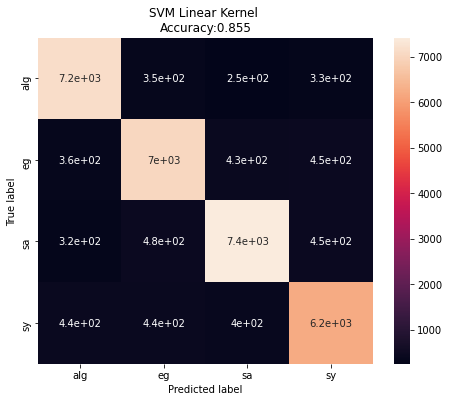

In [13]:
model.print_evaluate_reports()